In [2]:
# Importing necessary libraries for EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords') # /home/abdul-rehman/nltk_data

# Importing libraries necessary for Model Building and Training
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to /home/abdul-
[nltk_data]     rehman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Dataset
https://www.kaggle.com/datasets/yashpaloswal/spamham-email-classification-nlp

In [4]:
data = pd.read_csv('dataset/emails.csv')

In [5]:
data.head()

,Text,Spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


<Axes: xlabel='Spam', ylabel='count'>

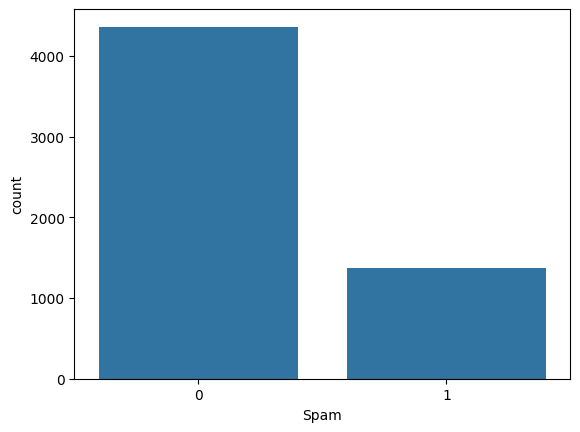

In [7]:
sns.countplot(x='Spam', data=data)

Text(0.5, 0, 'Message types')

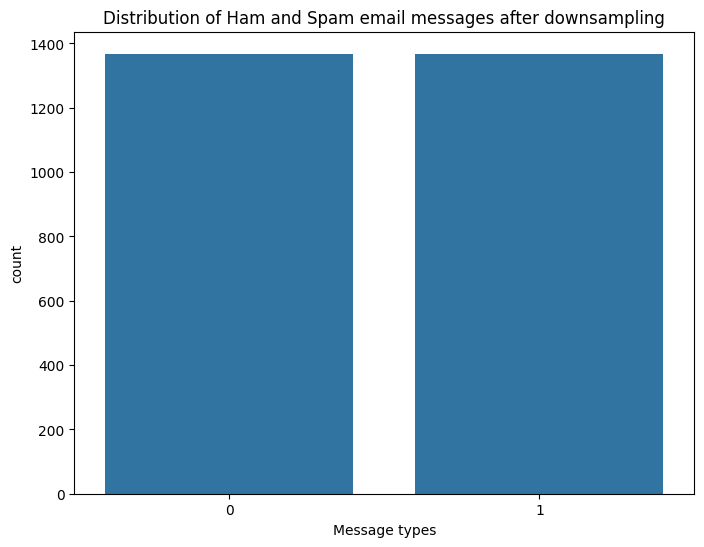

In [14]:
# Data shows class imbalance

# Downsampling to balance the dataset
ham_msg = data[data.Spam == 0]
spam_msg = data[data.Spam == 1]
ham_msg = ham_msg.sample(n=len(spam_msg), random_state=42)

# Plotting the counts of down sampled dataset
# Combine downsampled ham messages and spam messages
balanced_data = pd.concat([ham_msg, spam_msg]).reset_index(drop=True)


plt.figure(figsize=(8, 6))
sns.countplot(data=balanced_data, x='Spam')
plt.title('Distribution of Ham and Spam email messages after downsampling')
plt.xlabel('Message types')


In [27]:
balanced_data['Text'] = balanced_data['Text'].str.replace('Subject:', '')

In [29]:
balanced_data['Text'].iloc[0]

" interview schedule for jinbaek kim  i didn ' t see this before it went out , but i will be happy to meet with  jinbaek in the 11 : 00 am time slot , if you don ' t have anyone else scheduled  then . if not , i can easily meet with hiim after lunch .  molly  - - - - - - - - - - - - - - - - - - - - - - forwarded by molly magee / hou / ect on 01 / 17 / 2001 08 : 11  pm - - - - - - - - - - - - - - - - - - - - - - - - - - -  shawn grady @ enron  01 / 17 / 2001 06 : 02 pm  to : vince j kaminski / hou / ect @ ect , stinson gibner / hou / ect @ ect , tanya  tamarchenko / hou / ect @ ect , bob lee / na / enron @ enron , vasant shanbhogue / hou / ect @ ect  cc : shirley crenshaw / hou / ect @ ect , anita dupont / na / enron @ enron , molly  magee / hou / ect @ ect  subject : interview schedule for jinbaek kim  please find the interview packet for the above - referenced candidate . the  interview will occur on friday january 19 , 2001 . please print all documents  for your reference . if you ha

In [31]:
# Removing Punc
"""
    maketrans
        x: A string specifying the characters that need to be replaced.
        y: A string specifying the corresponding characters to replace with.
        z: A string specifying characters to delete
"""

punctuations_list = string.punctuation
def remove_punctuations(text):
	temp = str.maketrans('', '', punctuations_list)
	return text.translate(temp)

balanced_data['Text']= balanced_data['Text'].apply(lambda x: remove_punctuations(x))
balanced_data.head()


,Text,Spam
0,interview schedule for jinbaek kim i didn t...,0
1,re wednesday meeting eric i think we can ...,0
2,re london research group i d do it as soon...,0
3,re congratulations vince thanks for your n...,0
4,osman sezgen steve kromer is requesting that...,0


In [33]:
def remove_stopwords(text):
	stop_words = stopwords.words('english')

	imp_words = []

	for word in str(text).split():
		word = word.lower()

		if word not in stop_words:
			imp_words.append(word)

	output = " ".join(imp_words)

	return output


balanced_data['Text'] = balanced_data['Text'].apply(lambda text: remove_stopwords(text))
balanced_data.head()


,Text,Spam
0,interview schedule jinbaek kim see went happy ...,0
1,wednesday meeting eric think skip meeting disc...,0
2,london research group soon possible call exact...,0
3,congratulations vince thanks note congratulati...,0
4,osman sezgen steve kromer requesting osman spe...,0


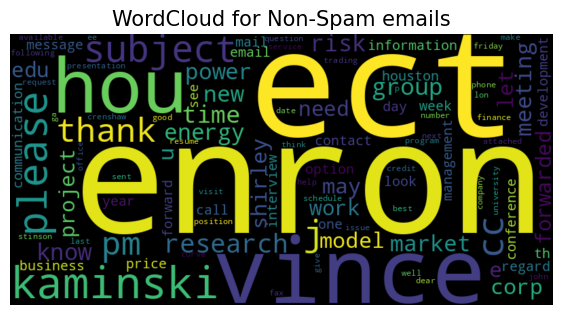

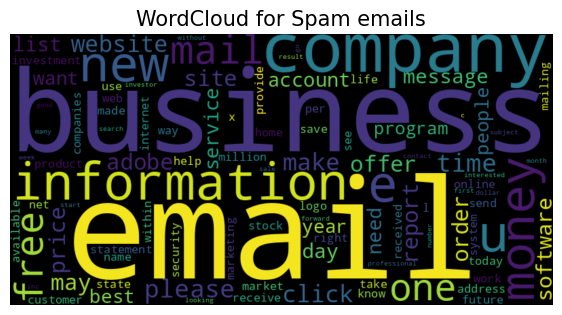

In [36]:
def plot_word_cloud(data, typ):
	email_corpus = " ".join(data['Text'])

	plt.figure(figsize=(7, 7))

	wc = WordCloud(background_color='black',
				max_words=100,
				width=800,
				height=400,
				collocations=False).generate(email_corpus)

	plt.imshow(wc, interpolation='bilinear')
	plt.title(f'WordCloud for {typ} emails', fontsize=15)
	plt.axis('off')
	plt.show()

plot_word_cloud(balanced_data[balanced_data['Spam'] == 0], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['Spam'] == 1], typ='Spam')


In [37]:
#train test split
train_X, test_X, train_Y, test_Y = train_test_split(balanced_data['Text'],
													balanced_data['Spam'],
													test_size = 0.2,
													random_state = 42)


In [38]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

# Pad sequences to have the same length
max_len = 100 # maximum sequence length
train_sequences = pad_sequences(train_sequences,
								maxlen=max_len, 
								padding='post', 
								truncating='post')
test_sequences = pad_sequences(test_sequences, 
							maxlen=max_len, 
							padding='post', 
							truncating='post')


In [39]:
model = tf.keras.models.Sequential([
    
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1,
        output_dim=32,
        input_length=max_len
    ),
    
    tf.keras.layers.LSTM(16),
    
    tf.keras.layers.Dense(32, activation='relu'),
    
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [40]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
	metrics = ['accuracy'],
	optimizer = 'adam'
)

In [42]:
es = EarlyStopping(patience=3,
	monitor = 'val_accuracy',
	restore_best_weights = True
)

lr = ReduceLROnPlateau(patience = 2,
	monitor = 'val_loss',
	factor = 0.5,
	verbose = 0
)

In [43]:
# Train the model
history = model.fit(train_sequences, train_Y,
	validation_data=(test_sequences, test_Y),
	epochs=20, 
	batch_size=32,
	callbacks = [lr, es]
)

Epoch 1/20
69/69 [==============================] - 3s 26ms/step - loss: 0.6119 - accuracy: 0.6650 - val_loss: 0.2374 - val_accuracy: 0.9453 - lr: 0.0010
Epoch 2/20
69/69 [==============================] - 1s 22ms/step - loss: 0.2148 - accuracy: 0.9442 - val_loss: 0.1461 - val_accuracy: 0.9672 - lr: 0.0010
Epoch 3/20
69/69 [==============================] - 2s 22ms/step - loss: 0.1302 - accuracy: 0.9749 - val_loss: 0.1433 - val_accuracy: 0.9708 - lr: 0.0010
Epoch 4/20
69/69 [==============================] - 2s 22ms/step - loss: 0.0546 - accuracy: 0.9909 - val_loss: 0.1085 - val_accuracy: 0.9763 - lr: 0.0010
Epoch 5/20
69/69 [==============================] - 2s 22ms/step - loss: 0.0286 - accuracy: 0.9959 - val_loss: 0.1274 - val_accuracy: 0.9745 - lr: 0.0010
Epoch 6/20
69/69 [==============================] - 1s 22ms/step - loss: 0.0169 - accuracy: 0.9977 - val_loss: 0.1383 - val_accuracy: 0.9745 - lr: 0.0010
Epoch 7/20
69/69 [==============================] - 2s 22ms/step - loss: 0.0

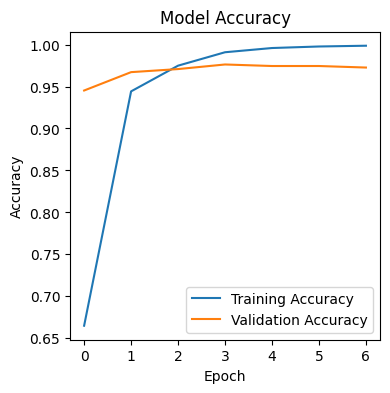

In [45]:
plt.figure(figsize=(4,4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()


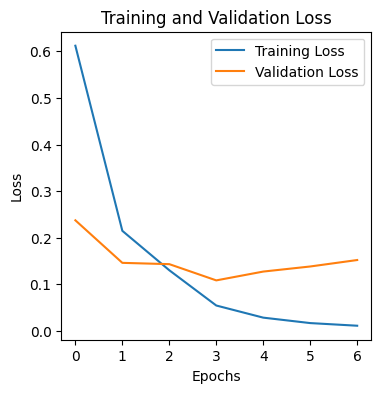

In [49]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(4,4))

# epochs = range(1, len(train_loss) + 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [53]:
loss, accuracy = model.evaluate(test_sequences, test_Y)

18/18 [==============================] - 0s 5ms/step - loss: 0.1085 - accuracy: 0.9763
